In [10]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [11]:
# Decoder function

def decoder(x,shift):
    inreach_chars = """!"#$%\'()*+,-./:;<=>?_¡£¥¿&¤0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÄÅÆÇÉÑØøÜßÖàäåæèéìñòöùüΔΦΓΛΩΠΨΣΘΞ"""
    extra_chars = {'@!':122,'@@':123,'@#':124,'@$':125,'@%':126,'@?':127}
    new_chars = inreach_chars[shift:] + inreach_chars[:shift]
    
    decoded = []
    counter = 0
    while(counter < len(x)):
        if x[counter] == '@':
            decoded.append("{0:07b}".format(extra_chars[x[counter:counter+2]]))
            counter = counter + 2
        else:
            decoded.append("{0:07b}".format(new_chars.index(x[counter])))
            counter = counter + 1
    
    decoded = ''.join(decoded)
    decoded = [decoded[i:i+4] for i in range(0, len(decoded), 4)]
    if len(decoded[-1]) < 4:
        del decoded[-1]
    decoded = [int(i,2) for i in decoded]
    mag = pd.Series(decoded[:int(len(decoded)/2)])
    dirs = pd.Series(decoded[int(len(decoded)/2):]).reset_index(drop=True)
    
    mag = mag*5
    v10 = np.sin(2*np.pi*dirs/16)*mag
    u10 = np.cos(2*np.pi*dirs/16)*mag
    
    idx = []
    for h in hours:
        for lat in np.arange(float(maxmin[0]),float(maxmin[1]) + float(interval[0]),float(interval[0])):
            for lon in np.arange(float(maxmin[2]),float(maxmin[3]) + float(interval[1]),float(interval[1])):
                idx.append({'hour':h,'lat':lat,'lon':lon})
    decoded = pd.DataFrame(idx)
    decoded['u10'] = u10
    decoded['v10'] = v10
    
    return decoded.set_index(['hour','lat','lon'])

In [25]:
# Copy all messages received from the inreach in here

TEXT_RECIEVED = """
36,48;2023-08-23 00:00:00;24.0,36.0,-72.0,-58.0;2.0,2.0;1START_MSG?+8>#+8#=g6#,+8>>+kg¤kgP¤oæ8¤oév>wÖ"+ke=,'8=+h$#+gCP¤k
0
1
A8>p+8>oéhw£EhZ3;$=ΛJ@%Φ)@!:æ@#£GpL1GxK!mxGxXÑ3üwQÖ;Δ¿CR.Θ$uÑüTv¤pL¤¤oæzVgCxGEND_MSG
1
"""


# Indicate your location for visuslisation

OUR_LOCATION = (-62.93,20.8219)

In [26]:
# Directly extracting the message data based on the markers
msg_start, msg_end = TEXT_RECIEVED.index("START_MSG"), TEXT_RECIEVED.index("END_MSG")
context = TEXT_RECIEVED[:msg_start] 
message_data = TEXT_RECIEVED[msg_start + 9:msg_end]  # +9 to skip "START_MSG"

# Splitting the context to extract individual pieces of data
context_lines = context.strip().split('\n')
times, gribtime, maxmin_str, diff_str, shift_str = context_lines[-1].split(';') # Getting the last line before START_MSG
hours = times.split(',')
maxmin = maxmin_str.split(',')
interval = diff_str.split(',')
shift = int(shift_str)

# Since your data is broken up with line numbers in between, let's remove those line numbers
message_parts = message_data.split('\n')
message_data_cleaned = ''.join(message_parts[::3])  # Keep every third line, skip the others

print(message_data_cleaned)

df = decoder(message_data_cleaned, shift)

?+8>#+8#=g6#,+8>>+kg¤kgP¤oæ8¤oév>wÖ"+ke=,'8=+h$#+gCP¤kA8>p+8>oéhw£EhZ3;$=ΛJ@%Φ)@!:æ@#£GpL1GxK!mxGxXÑ3üwQÖ;Δ¿CR.Θ$uÑüTv¤pL¤¤oæzVgCxG


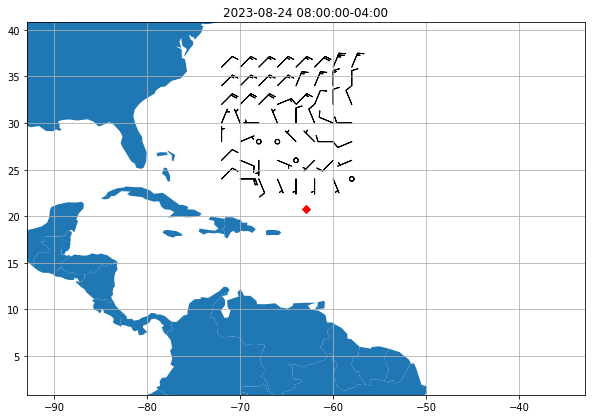

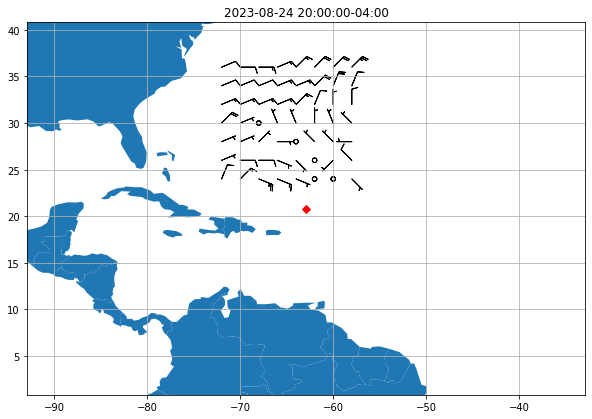

In [27]:
# Visualise encoded data
%matplotlib inline
#%matplotlib notebook # interactive version

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

for timepoint in df.index.get_level_values(0).unique():
    world.plot(figsize=(10,8))
    g = df.loc[timepoint].reset_index()
    plt.plot(OUR_LOCATION[0], OUR_LOCATION[1], marker='D',c='red')
    plt.barbs(g['lon'], g['lat'], g['u10'], g['v10'], length=5.5)
    
    plt.title((pd.to_datetime(gribtime) + pd.Timedelta(hours=int(timepoint))).tz_localize('UTC').tz_convert('US/Eastern'))
    plt.xlim([OUR_LOCATION[0]-30,OUR_LOCATION[0]+30])
    plt.ylim([OUR_LOCATION[1]-20,OUR_LOCATION[1]+20])
    plt.grid(True)
    plt.show()